# Atelier 1: Systèmes de Recherche d'Images par le Contenu CBIR - Descripteurs globaux

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from scipy.spatial.distance import euclidean
from skimage.feature import graycomatrix, graycoprops, hog
from skimage import exposure
import random

Définir les chemins vers les données

In [2]:
base_path = '/Users/Apple/Documents/5eme/Indexation _tatou/TP_1/obj_decoys'
requete_path = '/Users/Apple/Documents/5eme/Indexation _tatou/TP_1/img_requetes'

PARTIE 3.1: LECTURE DES IMAGES

In [ ]:
def load_images_from_folder(folder_path):
   
    images = []
    image_names = []
    
    for filename in os.listdir(folder_path):
        if filename.endswith(('.jpg', '.jpeg', '.png', '.bmp')):
            img_path = os.path.join(folder_path, filename)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                images.append(img)
                image_names.append(filename)
    
    return images, image_names

Question 1: Lire toutes les images et afficher 6 images aléatoirement


Nombre d'images dans la base: 270


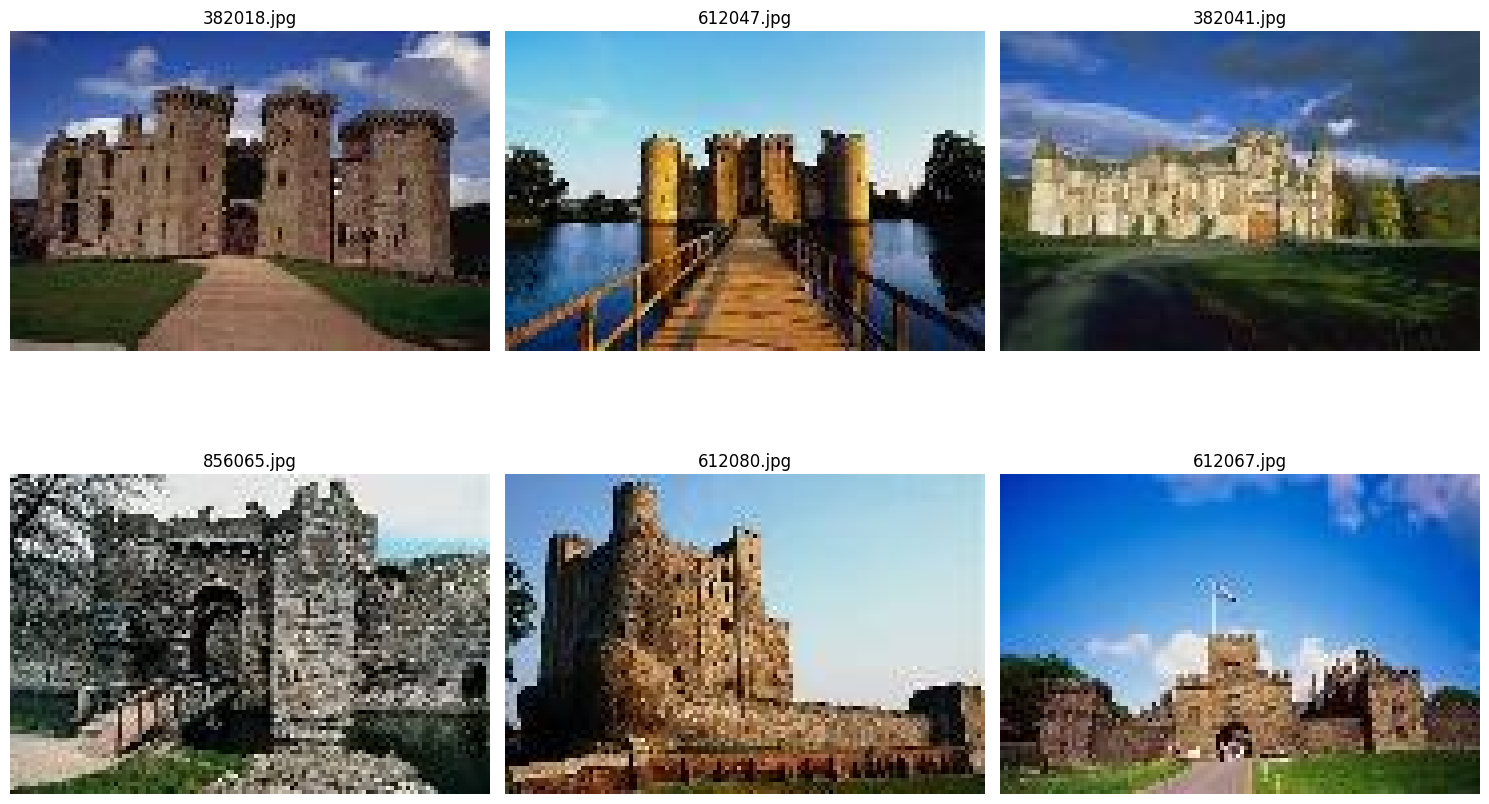

In [4]:
database_images, database_names = load_images_from_folder(base_path)
print(f"Nombre d'images dans la base: {len(database_images)}")

# Afficher 6 images aléatoires
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
random_indices = random.sample(range(len(database_images)), 6)

for idx, ax in enumerate(axes.flat):
    img_idx = random_indices[idx]
    ax.imshow(database_images[img_idx])
    ax.set_title(database_names[img_idx])
    ax.axis('off')

plt.tight_layout()
plt.show()

Question 2: Lire les images requêtes

Nombre d'images requêtes: 2


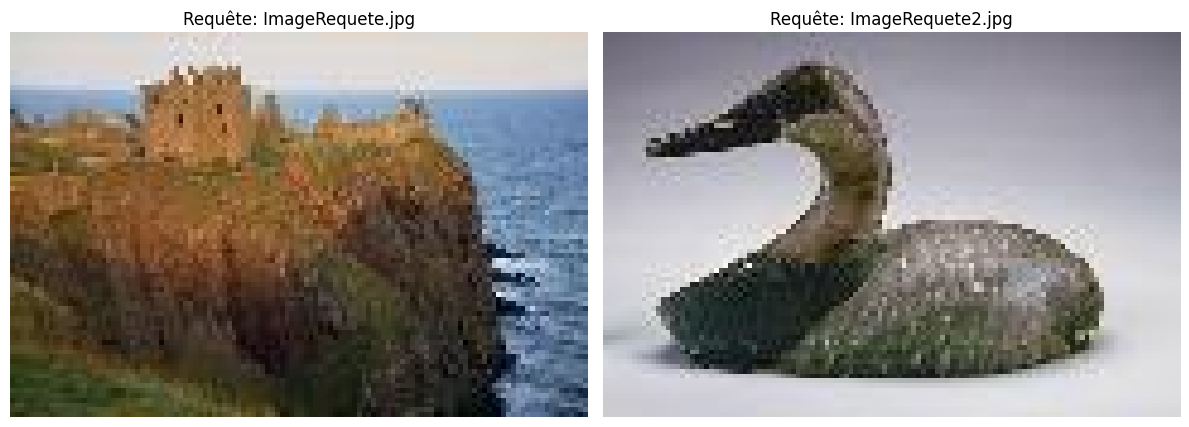

In [5]:
query_images, query_names = load_images_from_folder(requete_path)
print(f"Nombre d'images requêtes: {len(query_images)}")

# Afficher les images requêtes
fig, axes = plt.subplots(1, len(query_images), figsize=(12, 5))
for idx, (img, name) in enumerate(zip(query_images, query_names)):
    if len(query_images) > 1:
        axes[idx].imshow(img)
        axes[idx].set_title(f"Requête: {name}")
        axes[idx].axis('off')
    else:
        axes.imshow(img)
        axes.set_title(f"Requête: {name}")
        axes.axis('off')

plt.tight_layout()
plt.show()

PARTIE 3.2: RECHERCHE PAR IMAGE ENTIÈRE

In [6]:
def search_by_whole_image(query_img, database_imgs, database_names, top_k=5):
    """
    Recherche les images les plus similaires en utilisant la distance euclidienne
    entre les pixels des images entières.
    """
    query_resized = cv2.resize(query_img, (100, 100))
    query_flat = query_resized.flatten().astype(float)
    
    distances = {}
    
    # Calculer la distance avec chaque image de la base
    for idx, (img, name) in enumerate(zip(database_imgs, database_names)):
        img_resized = cv2.resize(img, (100, 100))
        img_flat = img_resized.flatten().astype(float)
        
        dist = euclidean(query_flat, img_flat)
        distances[idx] = dist
    
    sorted_results = sorted(distances.items(), key=lambda x: x[1])
    
    return sorted_results[:top_k]


Question 1 & 2: Appliquer la recherche et afficher les résultats

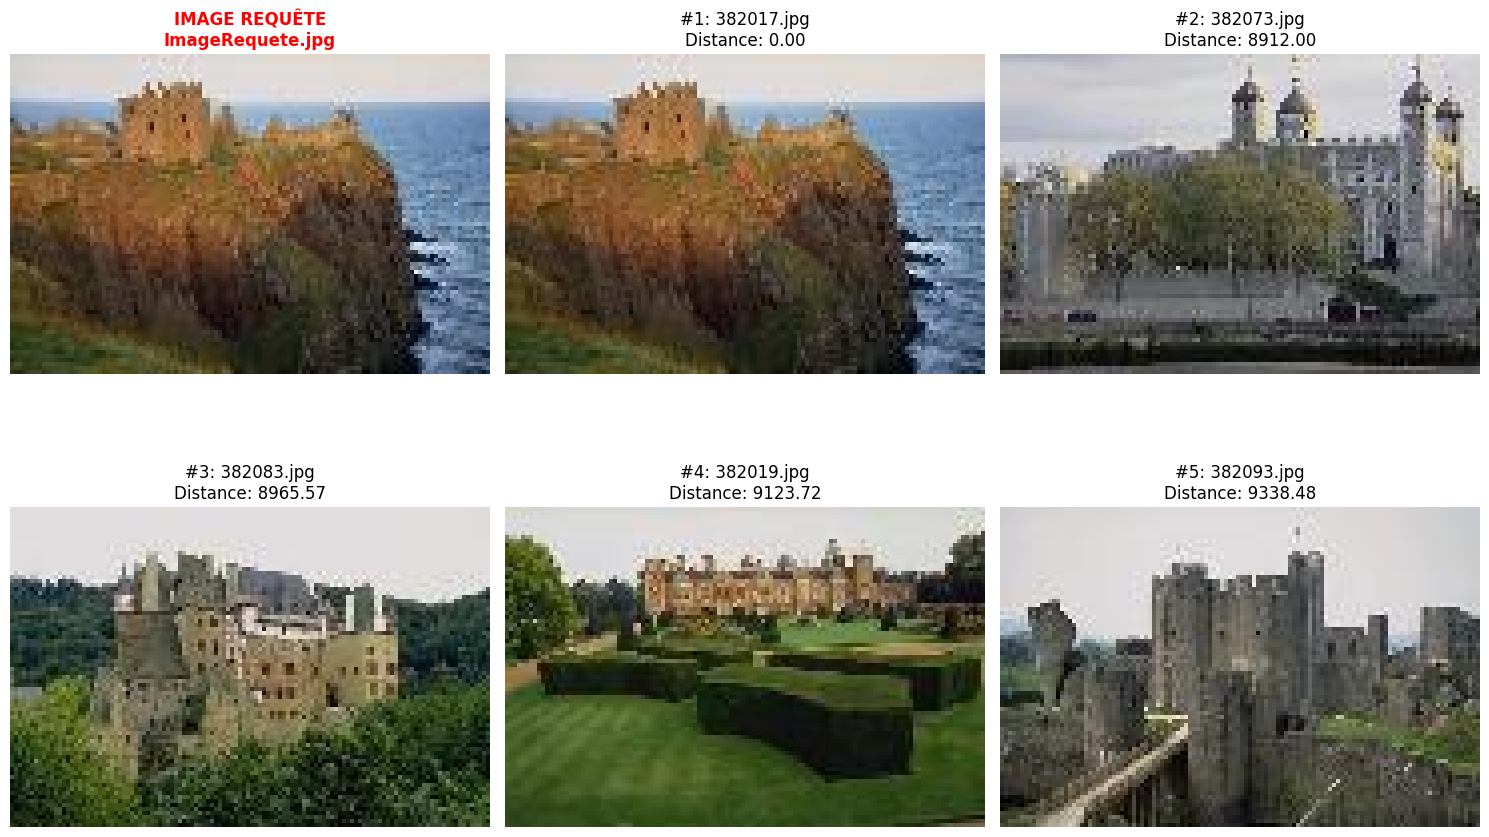

In [8]:
query_img = query_images[0]
results = search_by_whole_image(query_img, database_images, database_names)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

axes[0, 0].imshow(query_img)
axes[0, 0].set_title(f"IMAGE REQUÊTE\n{query_names[0]}", fontweight='bold', color='red')
axes[0, 0].axis('off')

# Afficher les 5 images les plus similaires
for idx, (img_idx, dist) in enumerate(results):
    row = (idx + 1) // 3
    col = (idx + 1) % 3
    axes[row, col].imshow(database_images[img_idx])
    axes[row, col].set_title(f"#{idx+1}: {database_names[img_idx]}\nDistance: {dist:.2f}")
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()


La recherche par image entière compare directement les pixels.
Cette méthode est sensible aux variations de luminosité, position, et échelle.
Les résultats peuvent ne pas être sémantiquement pertinents.

PARTIE 3.3: RECHERCHE PAR COULEUR


Indexation avec les moments de couleur...
Indexation de 270 images...
  50/270 images indexées...
  100/270 images indexées...
  150/270 images indexées...
  200/270 images indexées...
  250/270 images indexées...
Indexation terminée!
Matrice de caractéristiques: (270, 6)

Recherche avec les moments de couleur...


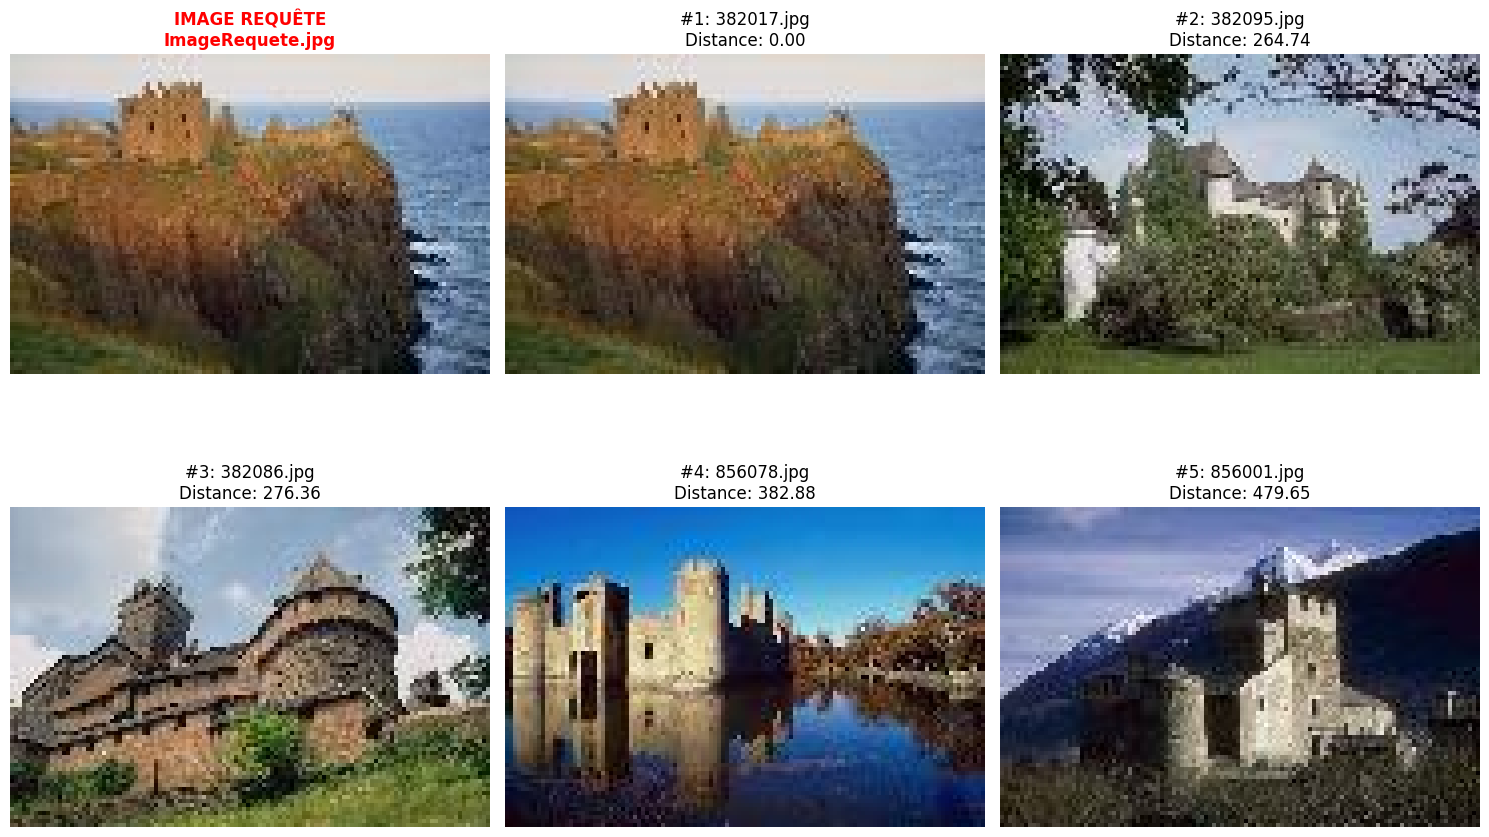

In [9]:
def color_Moments(img):
    """
    Calcule les moments statistiques (moyenne et variance) pour chaque canal couleur.
    """
    features = []
    
    # Calculer la moyenne et la variance pour chaque canal
    for channel in range(3):  # R, G, B
        channel_data = img[:, :, channel]
        mean = np.mean(channel_data)
        variance = np.var(channel_data)
        features.extend([mean, variance])
    
    return np.array(features)

def getFeatures(img, fsize):
    """
    Fonction générique pour extraire les caractéristiques d'une image.
    Cette fonction sera modifiée au fur et à mesure pour ajouter plus de descripteurs.
    """
    return color_Moments(img)

def CBIR_Indexation(images, image_names, fsize=6):
    """
    Phase d'indexation: extrait les caractéristiques de toutes les images.
    """
    print(f"Indexation de {len(images)} images...")
    
    features_matrix = []
    
    for idx, img in enumerate(images):
        features = getFeatures(img, fsize)
        features_matrix.append(features)
        
        if (idx + 1) % 50 == 0:
            print(f"  {idx + 1}/{len(images)} images indexées...")
    
    print("Indexation terminée!")
    return np.array(features_matrix), image_names

def CBIR_Recherche(img_requete, ind_Matrix, database_names, top_k=5):
    """
    Phase de recherche: trouve les images les plus similaires à l'image requête.
    """
    # Extraire les caractéristiques de l'image requête
    query_features = getFeatures(img_requete, ind_Matrix.shape[1])
    
    distances = {}
    
    # Calculer la distance avec chaque descripteur
    for idx in range(len(ind_Matrix)):
        dist = euclidean(query_features, ind_Matrix[idx])
        distances[idx] = dist
    
    # Trier par distance croissante
    sorted_results = sorted(distances.items(), key=lambda x: x[1])
    
    return sorted_results[:top_k]

# Indexation avec les moments de couleur
print("\nIndexation avec les moments de couleur...")
features_matrix, indexed_names = CBIR_Indexation(database_images, database_names, fsize=6)
print(f"Matrice de caractéristiques: {features_matrix.shape}")

# Recherche
print("\nRecherche avec les moments de couleur...")
results = CBIR_Recherche(query_images[0], features_matrix, indexed_names)

# Affichage
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

axes[0, 0].imshow(query_images[0])
axes[0, 0].set_title(f"IMAGE REQUÊTE\n{query_names[0]}", fontweight='bold', color='red')
axes[0, 0].axis('off')

for idx, (img_idx, dist) in enumerate(results):
    row = (idx + 1) // 3
    col = (idx + 1) % 3
    axes[row, col].imshow(database_images[img_idx])
    axes[row, col].set_title(f"#{idx+1}: {database_names[img_idx]}\nDistance: {dist:.2f}")
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

Les moments de couleur capturent la distribution des couleurs dans l'image.
On peut remarquer que les résultats sont meilleurs que la comparaison pixel par pixel. 

PARTIE 3.4: RECHERCHE PAR HISTOGRAMME

In [10]:
def hsvHistogramFeatures(img, bins=(8, 8, 8)):
    """
    Calcule l'histogramme HSV d'une image.
    
    """
    # Convertir RGB en HSV
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    
    # Calculer l'histogramme 3D
    hist = cv2.calcHist([hsv], [0, 1, 2], None, bins, 
                        [0, 180, 0, 256, 0, 256])
    
    # Normaliser l'histogramme
    hist = cv2.normalize(hist, hist).flatten()
    
    return hist
def getFeatures_v2(img, fsize):
    """
    Combine les moments de couleur et l'histogramme HSV.
    """
    moments = color_Moments(img)
    histogram = hsvHistogramFeatures(img)
    return np.concatenate([moments, histogram])

Question 1: Modifier getFeatures


Indexation de 270 images...
  50/270 images indexées...
  100/270 images indexées...
  150/270 images indexées...
  200/270 images indexées...
  250/270 images indexées...
Indexation terminée!
Matrice de caractéristiques: (270, 6)

Recherche avec couleur + histogramme...


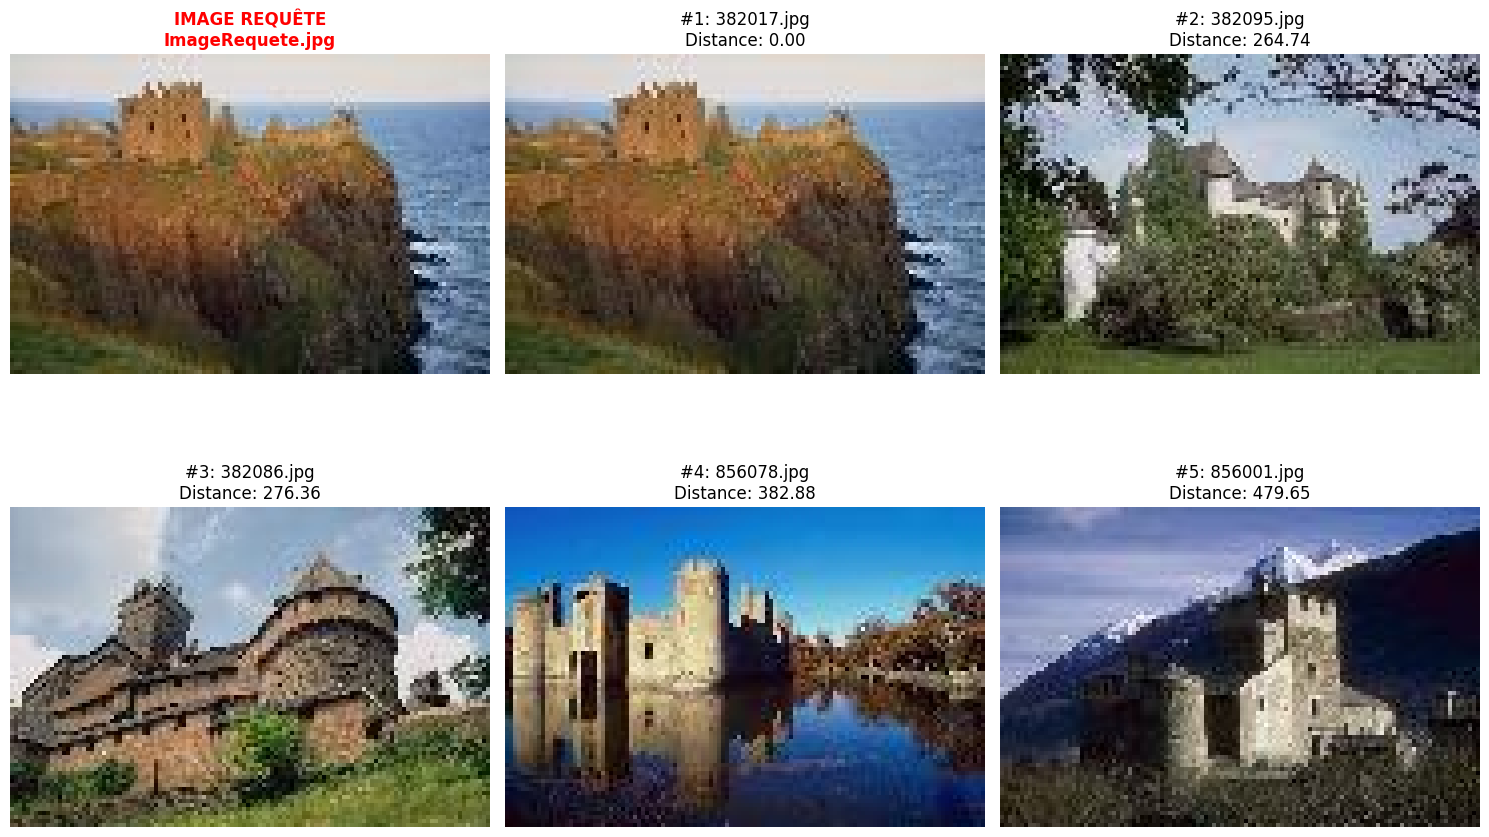

In [11]:
features_matrix_v2, indexed_names_v2 = CBIR_Indexation(database_images, database_names)
print(f"Matrice de caractéristiques: {features_matrix_v2.shape}")

print("\nRecherche avec couleur + histogramme...")
results_v2 = CBIR_Recherche(query_images[0], features_matrix_v2, indexed_names_v2)

# Affichage
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

axes[0, 0].imshow(query_images[0])
axes[0, 0].set_title(f"IMAGE REQUÊTE\n{query_names[0]}", fontweight='bold', color='red')
axes[0, 0].axis('off')

for idx, (img_idx, dist) in enumerate(results_v2):
    row = (idx + 1) // 3
    col = (idx + 1) % 3
    axes[row, col].imshow(database_images[img_idx])
    axes[row, col].set_title(f"#{idx+1}: {database_names[img_idx]}\nDistance: {dist:.2f}")
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

L'ajout de l'histogramme HSV améliore la discrimination des couleurs.
HSV est plus robuste aux variations d'éclairage que RGB.
Les résultats devraient être plus précis qu'avec les moments seuls.


PARTIE 3.5: RECHERCHE PAR TEXTURE

In [12]:
def textureFeatures(img):
    """
    Calcule les caractéristiques de texture basées sur GLCM.
    """
    # Convertir en niveaux de gris
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    glcm = graycomatrix(gray, distances=[1], angles=[0], levels=256, 
                        symmetric=True, normed=True)
    # Extraire les propriétés
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    
    return np.array([contrast, correlation, energy, homogeneity])

Question 2: Modifier getFeatures pour inclure la texture


In [13]:
def getFeatures_v3(img, fsize):
    """
    Combine couleur, histogramme et texture.
    """
    moments = color_Moments(img)
    histogram = hsvHistogramFeatures(img)
    
    # Texture
    texture = textureFeatures(img)
    
    # Concaténer tous les descripteurs
    return np.concatenate([moments, histogram, texture])

getFeatures = getFeatures_v3


Question 3: Réindexation avec couleur + histogramme + texture


Indexation de 270 images...
  50/270 images indexées...
  100/270 images indexées...
  150/270 images indexées...
  200/270 images indexées...
  250/270 images indexées...
Indexation terminée!
Matrice de caractéristiques: (270, 522)

Recherche avec tous les descripteurs...


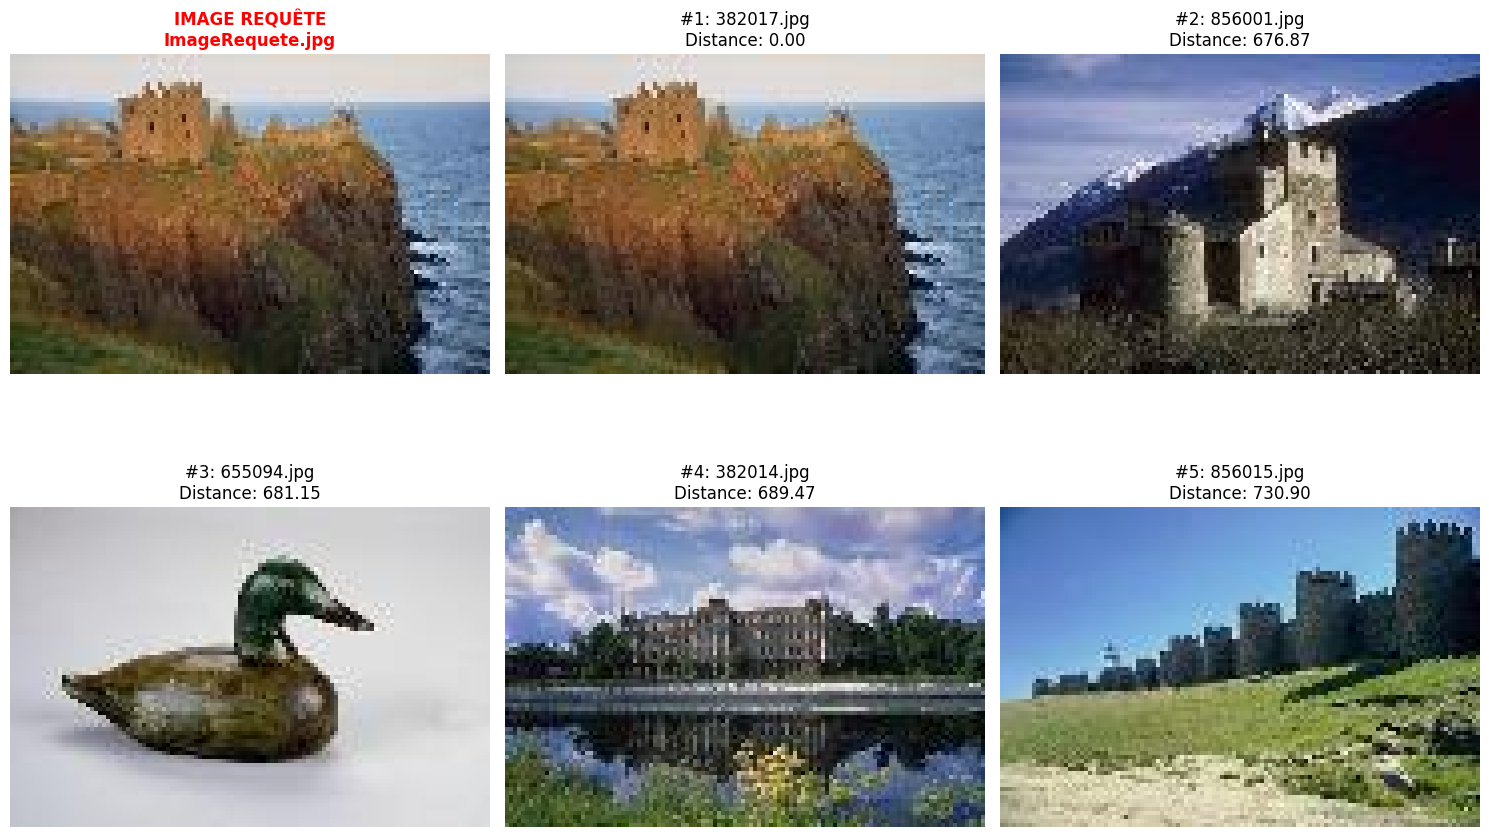

In [15]:
features_matrix_v3, indexed_names_v3 = CBIR_Indexation(database_images, database_names)
print(f"Matrice de caractéristiques: {features_matrix_v3.shape}")

print("\nRecherche avec tous les descripteurs...")
results_v3 = CBIR_Recherche(query_images[0], features_matrix_v3, indexed_names_v3)

# Affichage
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

axes[0, 0].imshow(query_images[0])
axes[0, 0].set_title(f"IMAGE REQUÊTE\n{query_names[0]}", fontweight='bold', color='red')
axes[0, 0].axis('off')

for idx, (img_idx, dist) in enumerate(results_v3):
    row = (idx + 1) // 3
    col = (idx + 1) % 3
    axes[row, col].imshow(database_images[img_idx])
    axes[row, col].set_title(f"#{idx+1}: {database_names[img_idx]}\nDistance: {dist:.2f}")
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

La texture apporte des informations sur les motifs et structures répétitives.
Les résultats combinent maintenant couleur ET texture pour une meilleure précision.

PARTIE 3.6: RECHERCHE PAR FORME (HOG)

In [16]:
def shapeFeaturesHOG(img):
    """
    Calcule le descripteur HOG (Histogram of Oriented Gradients).
    """
    # Convertir en niveaux de gris
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Redimensionner pour avoir une taille fixe
    gray_resized = cv2.resize(gray, (128, 128))
    hog_features = hog(gray_resized, 
                       orientations=9, 
                       pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2), 
                       block_norm='L2-Hys',
                       visualize=False)
    
    return hog_features

Question 3: Modifier getFeatures pour inclure HOG

In [17]:
def getFeatures_v4(img, fsize):
    """
    Combine couleur, histogramme, texture et forme (HOG).
    """
    # Moments de couleur
    moments = color_Moments(img)
    histogram = hsvHistogramFeatures(img)
    texture = textureFeatures(img)
    
    # Forme (HOG)
    shape = shapeFeaturesHOG(img)
    return np.concatenate([moments, histogram, texture, shape])

getFeatures = getFeatures_v4

Question 4: Réindexation et recherche avec descripteur complet


Indexation de 270 images...
  50/270 images indexées...
  100/270 images indexées...
  150/270 images indexées...
  200/270 images indexées...
  250/270 images indexées...
Indexation terminée!
Matrice de caractéristiques finale: (270, 8622)

Recherche pour: ImageRequete.jpg


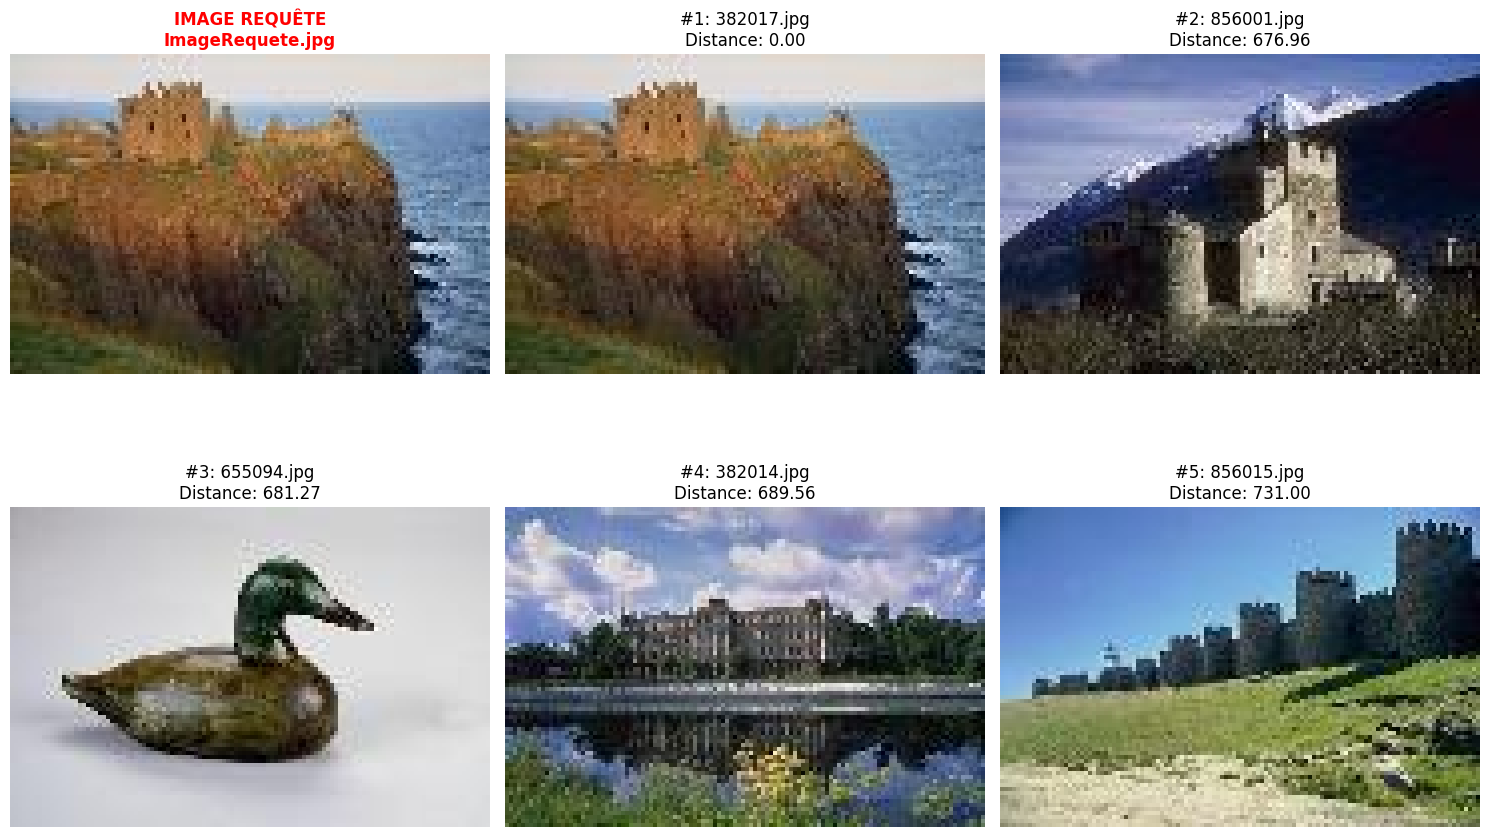


Recherche pour: ImageRequete2.jpg


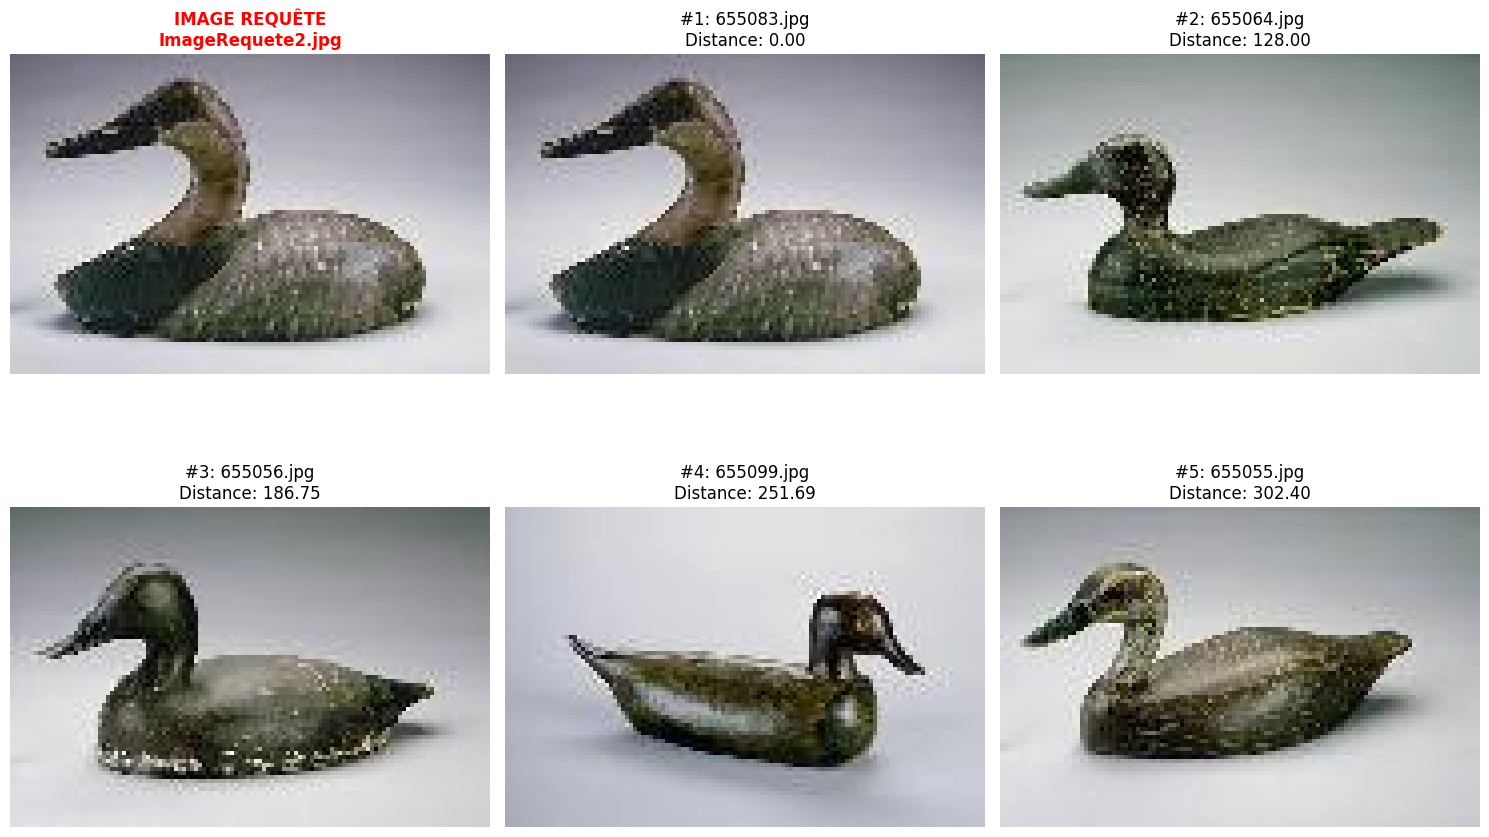

In [18]:
features_matrix_v4, indexed_names_v4 = CBIR_Indexation(database_images, database_names)
print(f"Matrice de caractéristiques finale: {features_matrix_v4.shape}")

# Recherche pour les deux images requêtes
for query_idx, (query_img, query_name) in enumerate(zip(query_images, query_names)):
    print(f"\n{'='*50}")
    print(f"Recherche pour: {query_name}")
    print(f"{'='*50}")
    
    results = CBIR_Recherche(query_img, features_matrix_v4, indexed_names_v4)
    
    # Affichage
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    axes[0, 0].imshow(query_img)
    axes[0, 0].set_title(f"IMAGE REQUÊTE\n{query_name}", fontweight='bold', color='red')
    axes[0, 0].axis('off')
    
    for idx, (img_idx, dist) in enumerate(results):
        row = (idx + 1) // 3
        col = (idx + 1) % 3
        axes[row, col].imshow(database_images[img_idx])
        axes[row, col].set_title(f"#{idx+1}: {database_names[img_idx]}\nDistance: {dist:.2f}")
        axes[row, col].axis('off')
    
    plt.tight_layout()
    plt.show()

HOG capture la forme et les contours des objets.
Le descripteur final combine: couleur + histogramme + texture + forme

Cette combinaison offre une représentation riche et discriminante des images.

PARTIE 3.7: ROBUSTESSE AUX TRANSFORMATIONS


Application des transformations géométriques...


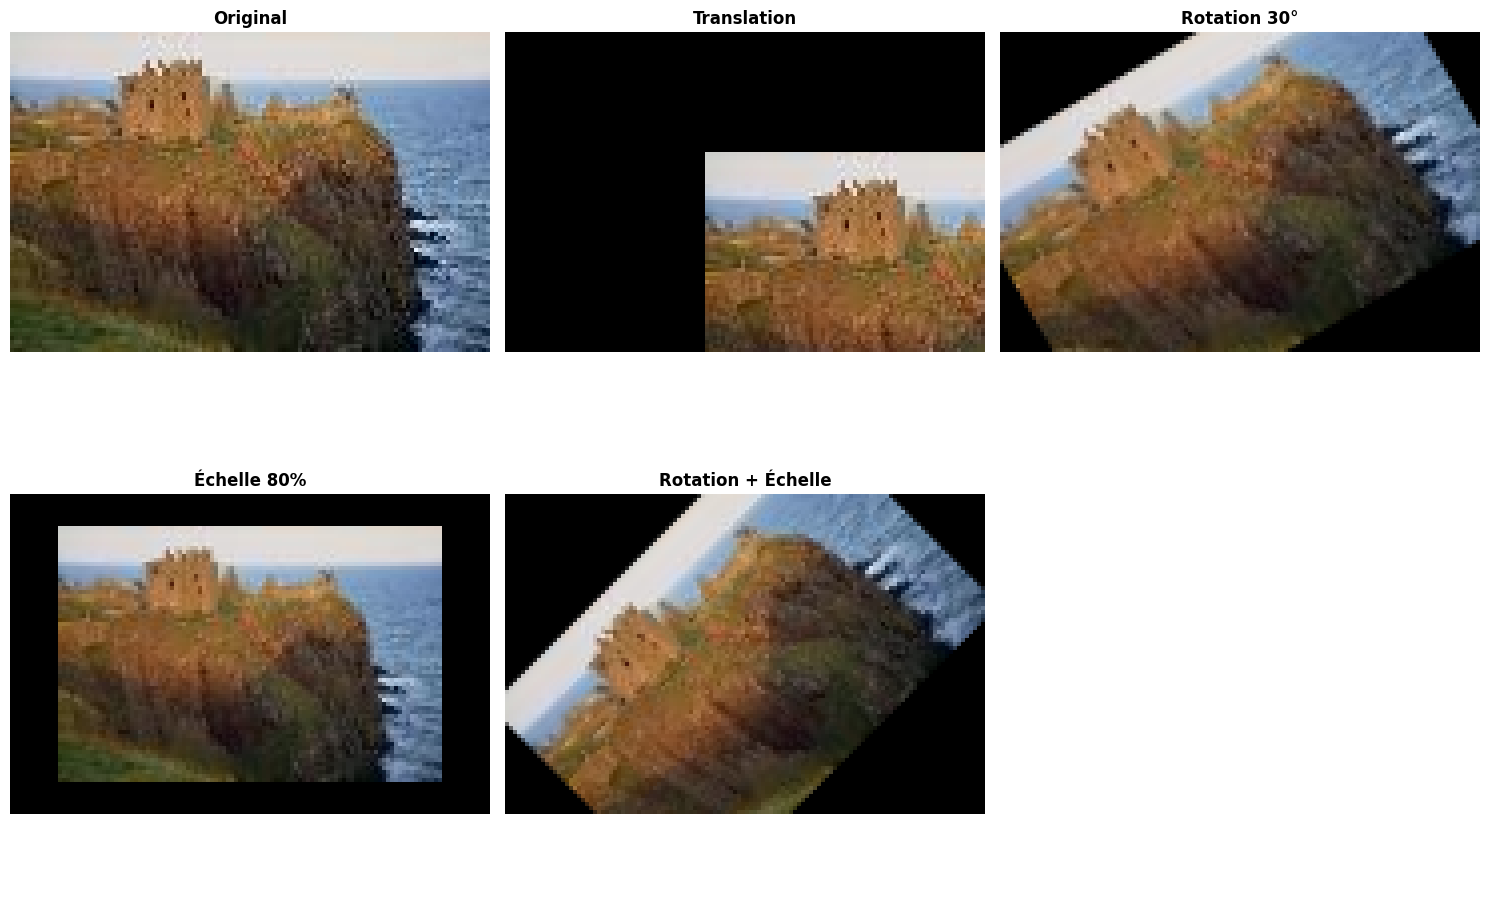


Test de robustesse avec les transformations:

──────────────────────────────────────────────────
Transformation: Original


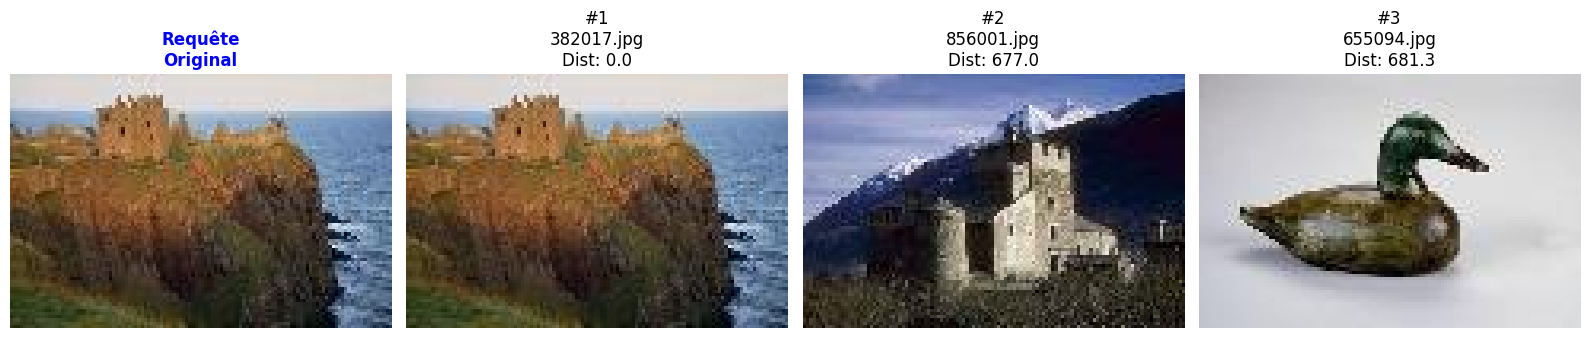

Transformation: Translation


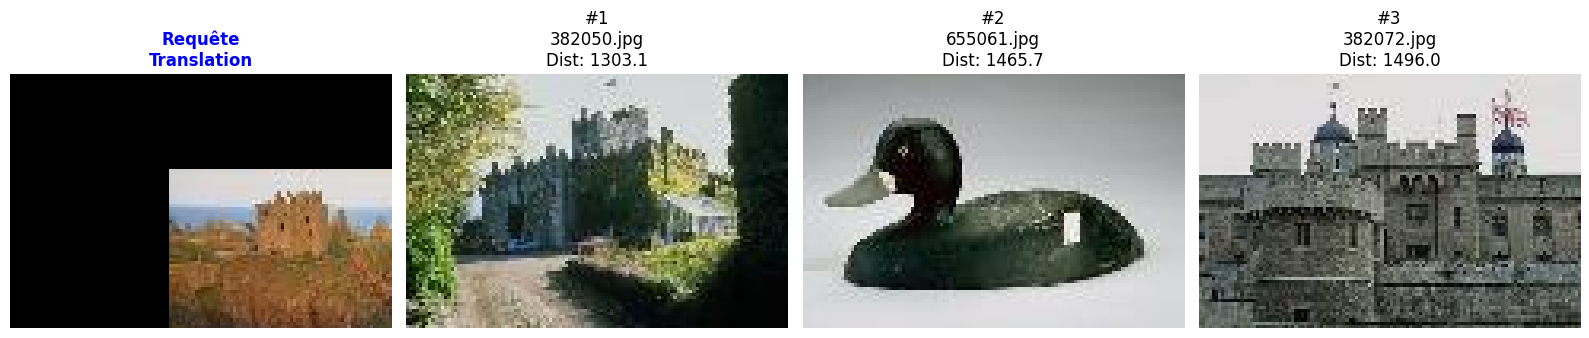

Transformation: Rotation 30°


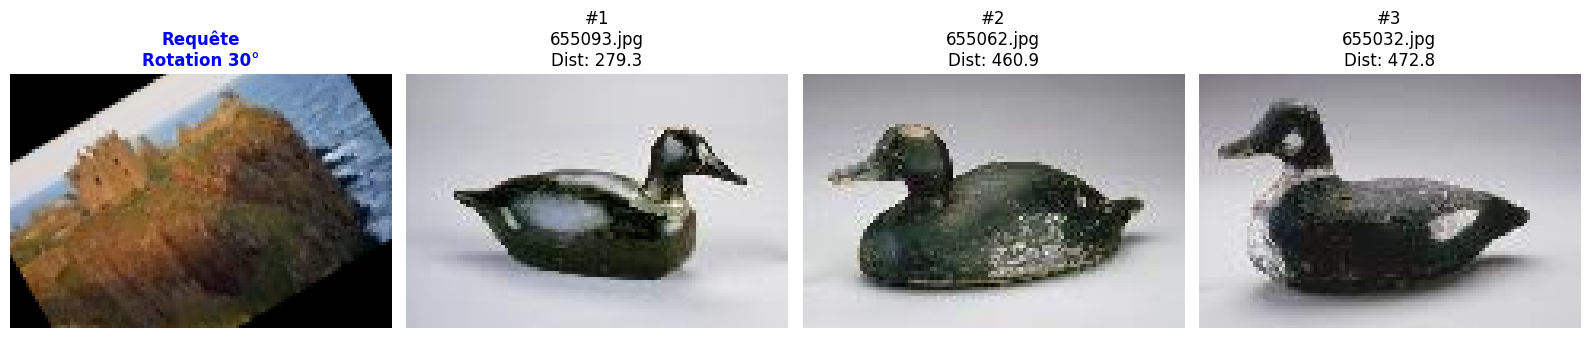

Transformation: Échelle 80%


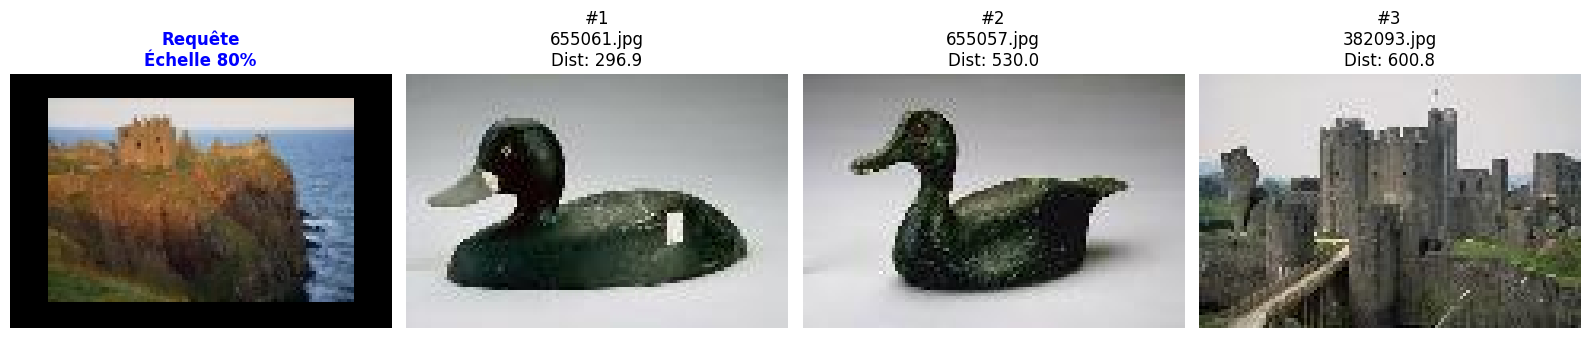

Transformation: Rotation + Échelle


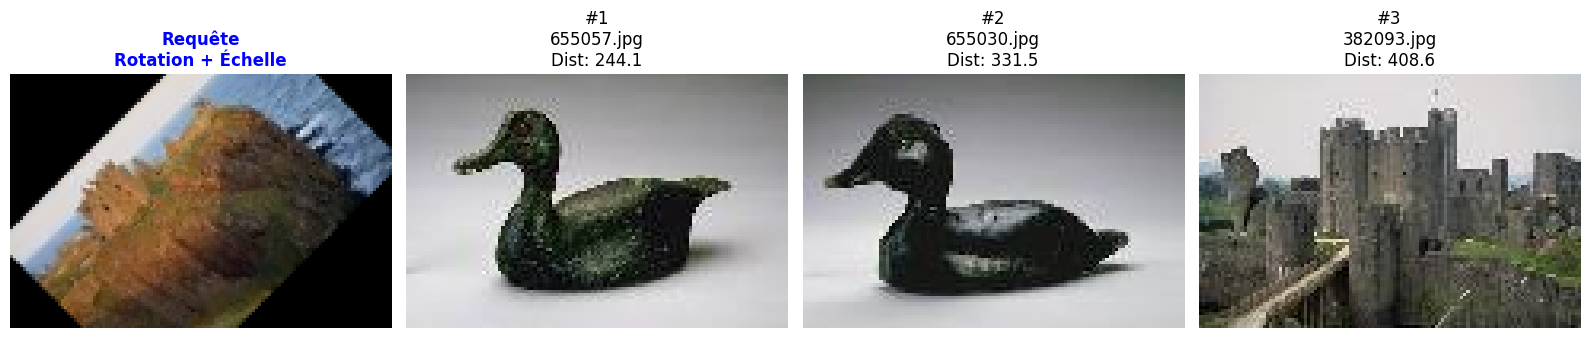

In [22]:
def apply_transformations(img):
    """
    Applique différentes transformations géométriques à une image.
    """
    transformations = {}
    
    # Image originale
    transformations['Original'] = img
    
    # Translation
    rows, cols = img.shape[:2]
    M_trans = np.float32([[1, 0, 50], [0, 1, 30]])
    translated = cv2.warpAffine(img, M_trans, (cols, rows))
    transformations['Translation'] = translated
    
    # Rotation (30 degrés)
    center = (cols // 2, rows // 2)
    M_rot = cv2.getRotationMatrix2D(center, 30, 1.0)
    rotated = cv2.warpAffine(img, M_rot, (cols, rows))
    transformations['Rotation 30°'] = rotated
    
    # Changement d'échelle (80%)
    scaled = cv2.resize(img, None, fx=0.8, fy=0.8)
    scaled_padded = cv2.copyMakeBorder(scaled, 
                                        (rows - scaled.shape[0]) // 2,
                                        (rows - scaled.shape[0]) - (rows - scaled.shape[0]) // 2,
                                        (cols - scaled.shape[1]) // 2,
                                        (cols - scaled.shape[1]) - (cols - scaled.shape[1]) // 2,
                                        cv2.BORDER_CONSTANT, value=[0, 0, 0])
    transformations['Échelle 80%'] = scaled_padded
    
    # Rotation + Échelle
    M_rot_scale = cv2.getRotationMatrix2D(center, 45, 0.9)
    rot_scaled = cv2.warpAffine(img, M_rot_scale, (cols, rows))
    transformations['Rotation + Échelle'] = rot_scaled
    
    return transformations

# Appliquer les transformations à la première image requête
print("\nApplication des transformations géométriques...")
query_img = query_images[0]
transformed_images = apply_transformations(query_img)

# Afficher les transformations
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for idx, (name, img) in enumerate(transformed_images.items()):
    row = idx // 3
    col = idx % 3
    axes[row, col].imshow(img)
    axes[row, col].set_title(name, fontweight='bold')
    axes[row, col].axis('off')

# Masquer le dernier subplot s'il est vide
if len(transformed_images) < 6:
    axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

# Tester la recherche avec chaque transformation
print("\nTest de robustesse avec les transformations:")
print(f"\n{'─'*50}")

for trans_name, trans_img in transformed_images.items():
    
    print(f"Transformation: {trans_name}")
    
    results = CBIR_Recherche(trans_img, features_matrix_v4, indexed_names_v4, top_k=3)
    
    # Affichage compact
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    
    axes[0].imshow(trans_img)
    axes[0].set_title(f"Requête\n{trans_name}", fontweight='bold', color='blue')
    axes[0].axis('off')
    
    for idx, (img_idx, dist) in enumerate(results):
        axes[idx + 1].imshow(database_images[img_idx])
        axes[idx + 1].set_title(f"#{idx+1}\n{database_names[img_idx]}\nDist: {dist:.1f}")
        axes[idx + 1].axis('off')
    
    plt.tight_layout()
    plt.show()


1. TRANSLATION: Les descripteurs globaux (moments, histogramme) sont généralement 
   invariants à la translation. Les résultats sont similaires à l'image d'origine.

2. ROTATION: HOG et GLCM sont sensibles à l'orientation.On peut remarquer qule Les résultats se sont dégradées.

3. ÉCHELLE: Le redimensionnement des images avant extraction aide, mais on remarque que les 
   résultats sont mauvaises. Les images données ne sont pas similaires à l'image d'origine.

4. COMBINAISON: Les transformations multiples accentuent les difficultés, et les résultats ont bien dégradées.
